# Coursera - Capstone - Hotel Recommendation System


### Importing Stuff and Setting Credentials

In [1]:
import pandas as pd
import numpy as np
import json
from xml.dom import minidom
import requests
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning) #Due to my network configuration I am disabling SSL. This line is to supress warnings.
%matplotlib inline
CLIENT_ID = 'A4B3N0TNM1SYNDB5U1ZJCIKTEQRWNZYPO0YQLJEDO1E1PAGT'
CLIENT_SECRET = 'FGLDG2V50BTNMPANGCH5T3ESSITZHXTJ1TFED0PVU3WIT54T'
VERSION = '20180605'

### Getting Toronto Data

In [2]:
#Getting the neighberhood data. Had to save the Wiki page locally due to Pandas parser not playing well with my VPN
page = pd.read_html('List of postal codes.htm',flavor ='bs4')
df = page[0] #Just the first table
df.rename(columns=df.iloc[0], inplace = True) # Use first row as headers
df.drop(df.index[0],inplace = True) # Drop the 1st row
df = df[df.Borough != 'Not assigned'] # Drop the postcodes without borough assigned.
df = df.groupby('Postcode').agg(lambda x:', '.join(set(x))) # More than one neighborhood can exist in one postal code area. These two rows will be combined into one row with the neighborhoods separated with a comma.
df.loc[df['Neighbourhood']=="Not assigned",'Neighbourhood']=df.loc[df['Neighbourhood']=="Not assigned",'Borough'] # Assign borou
df.head()


,Borough,Neighbourhood
Postcode,,
M1B,Scarborough,"Malvern, Rouge"
M1C,Scarborough,"Port Union, Highland Creek, Rouge Hill"
M1E,Scarborough,"Morningside, Guildwood, West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae


In [3]:
#Adding the geo data from the file provided in the labs
geo = pd.read_csv('Geospatial_Coordinates.csv')
df2 = pd.merge(df,geo,left_index = True, right_on = ['Postal Code'], how = 'left') #Merging
df2.rename(columns={'Postal Code':'PostalCode'},inplace = True)
neighborhoods = df2[['PostalCode','Borough','Neighbourhood','Latitude','Longitude']]
neighborhoods['City'] = 'Toronto'
toronto_neigh = neighborhoods[neighborhoods['Borough'].str.contains('Toronto')] #Filter to include only Toronto
toronto_neigh.drop(['PostalCode'], axis = 1, inplace = True)
toronto_neigh.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Borough,Neighbourhood,Latitude,Longitude,City
37,East Toronto,The Beaches,43.676357,-79.293031,Toronto
41,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,Toronto
42,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,Toronto
43,East Toronto,Studio District,43.659526,-79.340923,Toronto
44,Central Toronto,Lawrence Park,43.728020,-79.388790,Toronto


### Getting New-York Data

In [4]:
with open('ny_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']
ny_neigh = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    if borough == 'Manhattan': #Getting only Manhattan data due to API limitations.
        ny_neigh = ny_neigh.append({'Borough': borough,
                                    'Neighbourhood': neighborhood_name,
                                    'Latitude': neighborhood_lat,
                                    'Longitude': neighborhood_lon}, ignore_index=True)
ny_neigh['City'] = 'NY'
ny_neigh.head()

,Borough,Neighbourhood,Latitude,Longitude,City
0,Manhattan,Marble Hill,40.876551,-73.910660,NY
1,Manhattan,Chinatown,40.715618,-73.994279,NY
2,Manhattan,Washington Heights,40.851903,-73.936900,NY
3,Manhattan,Inwood,40.867684,-73.921210,NY
4,Manhattan,Hamilton Heights,40.823604,-73.949688,NY


### Getting London Data

In [5]:
london_raw = open("london.kml.txt", "r").read()

In [6]:
xmldoc = minidom.parseString(london_raw)
plist = xmldoc.getElementsByTagName('Placemark')
pdict = {'Neighbourhood': [], 'Latitude':[], 'Longitude':[]}
for p in plist:
    n = p.getElementsByTagName('name')[0].childNodes[0].data
    long, lat = p.getElementsByTagName('Point')[0].getElementsByTagName('coordinates')[0].childNodes[0].data.split(',')[0:2]
    long = float(long)
    lat = float(lat)
    if long < -1.0 or long > 1.0 or lat < 50.0 or lat > 52.0 or len(n) < 1:
        raise ValueError(n, lat, long, 'Out of bounds when reading in London Data')
    if n in pdict['Neighbourhood']:
        continue
    pdict['Neighbourhood'].append(n.strip())
    pdict['Latitude'].append(lat)
    pdict['Longitude'].append(long)
df_london = pd.DataFrame(pdict)
london_neigh = df_london[df_london['Neighbourhood'].str.contains('London')]
london_neigh['City'] = 'London' # Let's take only London center
london_neigh = london_neigh[london_neigh.Neighbourhood != "St Luke's, London"] #Dropping the silly neighberhood with ' in it's name
london_neigh.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Latitude,Longitude,Neighbourhood,City
1,51.513519,-0.270661,"Acton, London",London
2,51.510515,-0.262668,"Acton Green, London",London
3,51.511000,-0.258000,"Acton Vale, London",London
4,51.358300,-0.030500,"Addington, London",London
6,51.509167,-0.122500,"Adelphi, London",London


### Getting the Foursquare Data

In [7]:
#Borrowing the functions from the labs with small modifications:

# function that extracts the category of the venue
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url,verify = False).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [9]:
# Let's get the data for Toronto:
toronto_venues = getNearbyVenues(names=toronto_neigh['Neighbourhood'],
                                   latitudes=toronto_neigh['Latitude'],
                                   longitudes=toronto_neigh['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Summerhill East, Moore Park
South Hill, Rathnelly, Forest Hill SE, Deer Park, Summerhill West
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
King, Adelaide, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Victoria Hotel, Commerce Court
Roselawn
Forest Hill West, Forest Hill North
Yorkville, North Midtown, The Annex
Harbord, University of Toronto
Kensington Market, Chinatown, Grange Park
Railway Lands, King and Spadina, CN Tower, Island airport, Harbourfront West, Bathurst Quay, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Trinity, Little Portugal
Exhibition Place, Brockton, Parkdale Village
The Junction So

In [10]:
# Let's get the data for NY:
ny_venues = getNearbyVenues(names=ny_neigh['Neighbourhood'],
                                   latitudes=ny_neigh['Latitude'],
                                   longitudes=ny_neigh['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [11]:
# Let's get the data for London:
london_venues = getNearbyVenues(names=london_neigh['Neighbourhood'],
                                   latitudes=london_neigh['Latitude'],
                                   longitudes=london_neigh['Longitude']
                                  )

Acton, London
Acton Green, London
Acton Vale, London
Addington, London
Adelphi, London
Angel, London
Archway, London
Ashburton, London
Barking, London
Barnes, London
Barwell, London
Bedford Park, London
Bell Green, London
Bellingham, London
Belvedere, London
Blackfriars, London
Blackheath, London
Blackwall, London
Blendon, London
Botany Bay, London
Bow, London
Broad Green, London
Brompton, London
Castelnau, London
Castle Green, London
Central London
Charlton, London
Chinatown, London
Clapton, London
Clay Hill, London
College Park, London
Cowley, London
Cranbrook, London
Cranford, London
Crofton, London
Crystal Palace, London
Custom House, London
Cyprus, London
East End of London
East London
East Village, London
Eden Park, London
Edmonton, London
Elmstead, London
Farnborough, London
Farringdon, London
Fish Island, London
Forest Hill, London
Forestdale, London
Friday Hill, London
Fulwell, London
Gordon Hill, London
Greengate, London
Hainault, London
Ham, London
Hampton, London
Harlington

### Formating the data

Let's encode and create a DF with top 10 venues in NY per neighbourhood using the same(mostly) code from the labs:

In [12]:
onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="") #Encode Categories
onehot['Neighbourhood']  = ny_venues['Neighbourhood']
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns] #Move Neighbourhood to first column
ny_grouped = onehot.groupby('Neighbourhood').mean().reset_index()

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_ny = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_ny['Neighbourhood'] = ny_grouped['Neighbourhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted_ny.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_ny.head()




,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Memorial Site,Wine Shop,Italian Restaurant,Clothing Store,Gym,Plaza,Men's Store
1,Carnegie Hill,Coffee Shop,Pizza Place,Café,Yoga Studio,Bookstore,Wine Shop,Cosmetics Shop,French Restaurant,Bar,Japanese Restaurant
2,Central Harlem,African Restaurant,Public Art,Art Gallery,Seafood Restaurant,Chinese Restaurant,Gym / Fitness Center,French Restaurant,American Restaurant,Cosmetics Shop,Liquor Store
3,Chelsea,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bakery,Nightclub,Theater,Seafood Restaurant,American Restaurant,Hotel,Art Gallery
4,Chinatown,Chinese Restaurant,American Restaurant,Cocktail Bar,Spa,Dumpling Restaurant,Vietnamese Restaurant,Bubble Tea Shop,Optical Shop,Salon / Barbershop,Ice Cream Shop


In [13]:
ny_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,...,Volleyball Court,Watch Shop,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.0,0.0,0.0,0.00000,0.010000,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.03,0.0,0.02,0.00
1,Carnegie Hill,0.0,0.0,0.0,0.00000,0.010000,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.01,0.03,0.0,0.01,0.03
2,Central Harlem,0.0,0.0,0.0,0.06383,0.042553,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00
3,Chelsea,0.0,0.0,0.0,0.00000,0.030000,0.0,0.01,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0,0.01,0.00
4,Chinatown,0.0,0.0,0.0,0.00000,0.040000,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00


And now the same for Toronto:

In [14]:
onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="") #Encode Categories
onehot['Neighbourhood']  = toronto_venues['Neighbourhood']
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns] #Move Neighbourhood to first column
toronto_grouped = onehot.groupby('Neighbourhood').mean().reset_index()

num_top_venues = 10
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_toronto = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_toronto['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted_toronto.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_toronto.head()


,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Bakery,Café,Cheese Shop,Seafood Restaurant,Beer Bar,Italian Restaurant,Farmers Market
1,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Comic Shop,Pizza Place,Recording Studio,Restaurant,Butcher,Burrito Place,Skate Park,Brewery
2,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Middle Eastern Restaurant,Sandwich Place,Burger Joint,Japanese Restaurant,Ice Cream Shop,Spa,Bar
3,Christie,Café,Grocery Store,Park,Convenience Store,Coffee Shop,Baby Store,Nightclub,Diner,Italian Restaurant,Restaurant
4,Church and Wellesley,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Restaurant,Gay Bar,Men's Store,Gym,Pub,Mediterranean Restaurant,Bubble Tea Shop


And for London:

In [15]:
onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="") #Encode Categories
onehot['Neighbourhood']  = london_venues['Neighbourhood']
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns] #Move Neighbourhood to first column
london_grouped = onehot.groupby('Neighbourhood').mean().reset_index()

num_top_venues = 10
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_london = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_london['Neighbourhood'] = london_grouped['Neighbourhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted_london.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_london.head()

,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Acton Green, London",Pub,Grocery Store,Park,Wine Shop,Creperie,Bakery,Mini Golf,Convenience Store,Gym / Fitness Center,Train Station
1,"Acton Vale, London",Gym / Fitness Center,Pub,Park,Chinese Restaurant,Bakery,Train Station,Mini Golf,Yoshoku Restaurant,Farmers Market,Fast Food Restaurant
2,"Acton, London",Hotel,Grocery Store,Train Station,Park,Gas Station,Breakfast Spot,Convenience Store,Indian Restaurant,Bed & Breakfast,Flea Market
3,"Addington, London",Bus Station,English Restaurant,Tram Station,Gas Station,Yoshoku Restaurant,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field,Film Studio
4,"Adelphi, London",Hotel,Theater,Coffee Shop,Dessert Shop,Wine Bar,Tea Room,Italian Restaurant,Cocktail Bar,Burger Joint,French Restaurant


Let's combine the data frames for clustering:

In [51]:
neighborhoods_venues_sorted_ny['City'] = 'NY'
neighborhoods_venues_sorted_toronto['City'] = 'Toronto'
neighborhoods_venues_sorted_london['City'] = 'London'
toronto_grouped['City'] = 'Toronto'
ny_grouped['City'] = 'NY'
london_grouped['City'] = 'London'

combined = toronto_grouped.append(ny_grouped, ignore_index = True)
combined = combined.append(london_grouped, ignore_index = True)
combined_for_clustering = combined.drop(['Neighbourhood','City'],1)
combined_sorted = neighborhoods_venues_sorted_toronto.append(neighborhoods_venues_sorted_ny, ignore_index = True)
combined_sorted = combined_sorted.append(neighborhoods_venues_sorted_london, ignore_index = True)

In [52]:
print("Venue Type                 Number of Nan's")
print("==========                 ===============")
combined_for_clustering.isnull().sum(axis = 0) # The amount of NaN by column

Venue Type                 Number of Nan's
==========                 ===============


Accessories Store                 38
Adult Boutique                   138
Afghan Restaurant                  0
African Restaurant                38
Airport                          178
Airport Food Court               178
Airport Gate                     178
Airport Lounge                   178
Airport Service                  178
Airport Terminal                 178
American Restaurant                0
Animal Shelter                   176
Antique Shop                     138
Aquarium                         178
Arcade                           176
Arepa Restaurant                 176
Argentinian Restaurant            38
Art Gallery                        0
Art Museum                         0
Arts & Crafts Store                0
Asian Restaurant                   0
Athletics & Sports                38
Auditorium                       176
Australian Restaurant             38
Austrian Restaurant               38
Auto Garage                       78
Auto Workshop                    138
A

In [53]:
combined_for_clustering.dropna(axis='columns', inplace = True) # Drop the columns with NaN
#combined_for_clustering.fillna(0, inplace = True) #Replace NaN with zeros

### Clustering

Let's use the elbow method to find the optimal number of clusters

maximum is 0.2693044528206381, which occurs at k=6


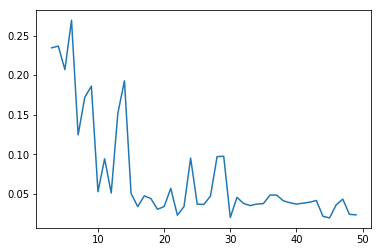

In [54]:
START = 3
END = 50
scores = []
for k in range(START, END):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(combined_for_clustering)
    
    scores.append(metrics.silhouette_score(combined_for_clustering, kmeans.labels_))   
kclusters=np.argmax(scores)+START
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
plt.plot(range(START,END),scores)

Hmm, it seems our model won't be really accurate. The best K is 6, however it creats a single "useful" cluster and a lot of clusters with a single row.
There is a another peak in the 30-35 area, so let's zoom there.

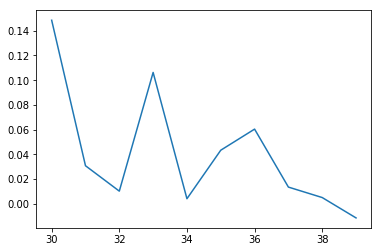

In [32]:
plt.plot(range(30,40),scores[27:37])

More clusters is better in our case, so let's go for 29.

In [55]:
kclusters = 29
kmeans = KMeans(n_clusters=kclusters).fit(combined_for_clustering)
combined_sorted.insert(0, 'Cluster',kmeans.labels_ )

Let's examine our clusters and check if they accomadiate our goal:

In [56]:
combined_sorted.groupby(['Cluster','City']).count()

Neighbourhood  1th Most Common Venue  2th Most Common Venue  \
Cluster City                                                                   
0       London              17                     17                     17   
        NY                  30                     30                     30   
        Toronto              5                      5                      5   
1       London               4                      4                      4   
        Toronto              1                      1                      1   
2       London               1                      1                      1   
3       London               1                      1                      1   
4       London               5                      5                      5   
        Toronto              1                      1                      1   
5       London               1                      1                      1   
6       London              10                     10                     10   
        NY                  10                     10                     10   
        Toronto              6                      6                      6   
7       London              28                     28                     28   
        Toronto             19                     19                     19   
8       London               1                      1                      1   
9       Toronto              1                      1                      1   
10      London               8                      8                      8   
11      Toronto              1                      1                      1   
12      London               1                      1                      1   
13      London               1                      1                      1   
14      London               1                      1                      1   
15      Toronto              1                      1                      1   
16      London               5                      5                      5   
17      London               1                      1                      1   
18      London               4                      4                      4   
19      London              13                     13                     13   
20      London              12                     12                     12   
21      Toronto              1                      1                      1   
22      London               2                      2                      2   
23      London               1                      1                      1   
24      London               1                      1                      1   
25      London               2                      2                      2   
26      London              16                     16                     16   
        Toronto              2                      2                      2   
27      London               1                      1                      1   
28      London               1                      1                      1   

                 3th Most Common Venue  4th Most Common Venue  \
Cluster City                                                    
0       London                      17                     17   
        NY                          30                     30   
        Toronto                      5                      5   
1       London                       4                      4   
        Toronto                      1                      1   
2       London                       1                      1   
3       London                       1                      1   
4       London                       5                      5   
        Toronto                      1                      1   
5       London                       1                      1   
6       London                      10                     10   
        NY                          10             

It looks like partial success.
We have several clusters that can be useful becuase they contain neighberhoods from diffrent cities.
The other clusters that contain a single neighberhood can be classified as unsuitable for our model, since they don't have an analogue in other cities.
Let's check the interesting clusters:

In [ ]:
useful_clusters = (0,1,4,6,7,26)

In [68]:
#Cluster 1
combined_sorted.loc[combined_sorted['Cluster'] == 0, combined_sorted.columns[[1] + list(range(2, combined_sorted.shape[1]))]]

,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
4,Church and Wellesley,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Restaurant,Gay Bar,Men's Store,Gym,Pub,Mediterranean Restaurant,Bubble Tea Shop,Toronto
16,"Kensington Market, Chinatown, Grange Park",Café,Vegetarian / Vegan Restaurant,Bakery,Mexican Restaurant,Coffee Shop,Dumpling Restaurant,Bar,Vietnamese Restaurant,Chinese Restaurant,Cocktail Bar,Toronto
17,"King, Adelaide, Richmond",Coffee Shop,Café,Steakhouse,Bar,American Restaurant,Bakery,Restaurant,Hotel,Burger Joint,Cosmetics Shop,Toronto
20,"Railway Lands, King and Spadina, CN Tower, Isl...",Airport Terminal,Airport Lounge,Airport Service,Plane,Sculpture Garden,Boat or Ferry,Boutique,Harbor / Marina,Bar,Airport Gate,Toronto
35,"Trinity, Little Portugal",Bar,Asian Restaurant,Men's Store,Coffee Shop,Pizza Place,New American Restaurant,Restaurant,Vietnamese Restaurant,Café,Cocktail Bar,Toronto
39,Carnegie Hill,Coffee Shop,Pizza Place,Café,Yoga Studio,Bookstore,Wine Shop,Cosmetics Shop,French Restaurant,Bar,Japanese Restaurant,NY
40,Central Harlem,African Restaurant,Public Art,Art Gallery,Seafood Restaurant,Chinese Restaurant,Gym / Fitness Center,French Restaurant,American Restaurant,Cosmetics Shop,Liquor Store,NY
41,Chelsea,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bakery,Nightclub,Theater,Seafood Restaurant,American Restaurant,Hotel,Art Gallery,NY
42,Chinatown,Chinese Restaurant,American Restaurant,Cocktail Bar,Spa,Dumpling Restaurant,Vietnamese Restaurant,Bubble Tea Shop,Optical Shop,Salon / Barbershop,Ice Cream Shop,NY
43,Civic Center,Italian Restaurant,Gym / Fitness Center,Coffee Shop,French Restaurant,Sandwich Place,Bakery,Yoga Studio,Sporting Goods Shop,American Restaurant,Spa,NY


In [69]:
#Cluster 2
combined_sorted.loc[combined_sorted['Cluster'] == 1, combined_sorted.columns[[1] + list(range(2, combined_sorted.shape[1]))]]

,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
3,Christie,Café,Grocery Store,Park,Convenience Store,Coffee Shop,Baby Store,Nightclub,Diner,Italian Restaurant,Restaurant,Toronto
91,"Bellingham, London",Grocery Store,Gym,Park,Train Station,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,London
116,East End of London,Park,Grocery Store,Bakery,Fried Chicken Joint,Thrift / Vintage Store,Farm,Indian Restaurant,Flower Shop,Pub,Chinese Restaurant,London
163,"Northfields, London",Grocery Store,Italian Restaurant,Park,Café,Pub,Chinese Restaurant,Cheese Shop,French Restaurant,Deli / Bodega,Kebab Restaurant,London
186,"St Ann's, London",Park,Café,Grocery Store,Hostel,Fish & Chips Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,London


In [70]:
#Cluster 3
combined_sorted.loc[combined_sorted['Cluster'] == 4, combined_sorted.columns[[1] + list(range(2, combined_sorted.shape[1]))]]

,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
18,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Doner Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Toronto
85,"Ashburton, London",Tram Station,Park,Chinese Restaurant,African Restaurant,Yoshoku Restaurant,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field,Film Studio,London
133,"Hampton, London",Park,Fried Chicken Joint,Coffee Shop,Yoshoku Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,London
153,"Manor Park, London",Gas Station,Restaurant,Fried Chicken Joint,Turkish Restaurant,Park,Film Studio,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,London
157,"Mitcham, London",Construction & Landscaping,Bus Stop,Bookstore,Park,Yoshoku Restaurant,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,London
165,"Northwood, London",Park,Soccer Field,Gym / Fitness Center,Golf Course,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Yoshoku Restaurant,London


In [71]:
#Cluster 4
combined_sorted.loc[combined_sorted['Cluster'] == 6, combined_sorted.columns[[1] + list(range(2, combined_sorted.shape[1]))]]

,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
1,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Comic Shop,Pizza Place,Recording Studio,Restaurant,Butcher,Burrito Place,Skate Park,Brewery,Toronto
6,Davisville North,Playground,Hotel,Clothing Store,Food & Drink Shop,Grocery Store,Park,Gym,Breakfast Spot,Sandwich Place,Falafel Restaurant,Toronto
8,"Dufferin, Dovercourt Village",Supermarket,Pharmacy,Bakery,Brazilian Restaurant,Bank,Brewery,Music Venue,Discount Store,Coffee Shop,Café,Toronto
15,"India Bazaar, The Beaches West",Park,Gym,Italian Restaurant,Pizza Place,Pub,Movie Theater,Sandwich Place,Burrito Place,Burger Joint,Brewery,Toronto
19,North Toronto West,Coffee Shop,Yoga Studio,Bagel Shop,Park,Clothing Store,Dessert Shop,Chinese Restaurant,Rental Car Location,Diner,Salon / Barbershop,Toronto
34,"The Junction South, High Park",Bar,Mexican Restaurant,Café,Fast Food Restaurant,Fried Chicken Joint,Bakery,Italian Restaurant,Gastropub,Music Venue,Arts & Crafts Store,Toronto
38,Battery Park City,Park,Coffee Shop,Hotel,Memorial Site,Wine Shop,Italian Restaurant,Clothing Store,Gym,Plaza,Men's Store,NY
45,East Harlem,Mexican Restaurant,Deli / Bodega,Bakery,Latin American Restaurant,Thai Restaurant,Convenience Store,Café,Gas Station,Taco Place,Steakhouse,NY
51,Hamilton Heights,Deli / Bodega,Café,Mexican Restaurant,Pizza Place,Chinese Restaurant,Coffee Shop,Sushi Restaurant,Caribbean Restaurant,School,Bakery,NY
53,Inwood,Mexican Restaurant,Café,Lounge,Bakery,Pizza Place,Park,Frozen Yogurt Shop,Chinese Restaurant,Deli / Bodega,American Restaurant,NY


In [72]:
#Cluster 5
combined_sorted.loc[combined_sorted['Cluster'] == 7, combined_sorted.columns[[1] + list(range(2, combined_sorted.shape[1]))]]

,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
0,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Bakery,Café,Cheese Shop,Seafood Restaurant,Beer Bar,Italian Restaurant,Farmers Market,Toronto
2,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Middle Eastern Restaurant,Sandwich Place,Burger Joint,Japanese Restaurant,Ice Cream Shop,Spa,Bar,Toronto
5,Davisville,Pizza Place,Dessert Shop,Sandwich Place,Italian Restaurant,Café,Thai Restaurant,Sushi Restaurant,Coffee Shop,Restaurant,Deli / Bodega,Toronto
7,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Café,Hotel,Restaurant,Gastropub,Deli / Bodega,Italian Restaurant,Bakery,American Restaurant,Pizza Place,Toronto
9,"Exhibition Place, Brockton, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Yoga Studio,Intersection,Performing Arts Venue,Caribbean Restaurant,Stadium,Restaurant,Bar,Toronto
10,"First Canadian Place, Underground city",Coffee Shop,Café,Hotel,Steakhouse,Restaurant,Bar,Deli / Bodega,Seafood Restaurant,Gastropub,American Restaurant,Toronto
12,"Garden District, Ryerson",Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Tea Room,Italian Restaurant,Diner,Pizza Place,Bubble Tea Shop,Toronto
13,"Harbord, University of Toronto",Café,Italian Restaurant,Japanese Restaurant,Bar,Bookstore,Restaurant,Bakery,College Gym,Chinese Restaurant,Beer Bar,Toronto
14,"Harbourfront East, Toronto Islands, Union Station",Coffee Shop,Aquarium,Hotel,Restaurant,Café,Italian Restaurant,Scenic Lookout,Sporting Goods Shop,Brewery,Fried Chicken Joint,Toronto
21,"Regent Park, Harbourfront",Coffee Shop,Bakery,Pub,Park,Theater,Breakfast Spot,Restaurant,Mexican Restaurant,Café,Yoga Studio,Toronto


In [73]:
#Cluster 6
combined_sorted.loc[combined_sorted['Cluster'] == 26, combined_sorted.columns[[1] + list(range(2, combined_sorted.shape[1]))]]

,Neighbourhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
25,"South Hill, Rathnelly, Forest Hill SE, Deer Pa...",Pub,Coffee Shop,Liquor Store,Light Rail Station,Sushi Restaurant,Supermarket,Sports Bar,Fried Chicken Joint,American Restaurant,Vietnamese Restaurant,Toronto
32,The Beaches,Health Food Store,Pub,Trail,Neighborhood,Other Great Outdoors,Falafel Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Toronto
78,"Acton Green, London",Pub,Grocery Store,Park,Wine Shop,Creperie,Bakery,Mini Golf,Convenience Store,Gym / Fitness Center,Train Station,London
79,"Acton Vale, London",Gym / Fitness Center,Pub,Park,Chinese Restaurant,Bakery,Train Station,Mini Golf,Yoshoku Restaurant,Farmers Market,Fast Food Restaurant,London
102,"Castle Green, London",Skate Park,Go Kart Track,Pub,Rugby Pitch,Field,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,London
125,"Forest Hill, London",Pub,Coffee Shop,Café,Grocery Store,Gym / Fitness Center,Train Station,Bookstore,Indian Restaurant,Thai Restaurant,Gastropub,London
128,"Fulwell, London",Pizza Place,Bus Station,Golf Course,Pub,Diner,Seafood Restaurant,Convenience Store,Fast Food Restaurant,Chinese Restaurant,Garden Center,London
134,"Harlington, London",Restaurant,Indian Restaurant,Pub,Bus Stop,Gym / Fitness Center,Rental Car Location,Café,Hotel,Pool,Grocery Store,London
138,"Holloway, London",Pub,Coffee Shop,Café,Fast Food Restaurant,Bus Stop,Bakery,Grocery Store,Gym / Fitness Center,Supermarket,Ethiopian Restaurant,London
148,"Little Russia, London",Pub,Fried Chicken Joint,Pizza Place,Fish & Chips Shop,Gas Station,Supermarket,Chinese Restaurant,Lounge,Train Station,Turkish Restaurant,London
